# Learning to optimize parametric Quadratic Programming (pQP) problems using Neuromancer with a trainable correction layer for improved feasibility and optimality.


This is an interactive notebook based on the python script [Part_6_pqp_lopoCorrection.py](./Part_6_pQp_lopoCorrection.py). 

We demonstrate how the NeuroMANCER toolbox can be used to solve a parametric quadratic program and implement a learned operator splitting method as a final layer to improve solutions.

Problem formulation pQP:
$$
    \begin{align}
    &\text{minimize } &&   x^2 + y^2\\
    &\text{subject to} &&  -x - y + p1 \le 0\\
    &  &&    x + y - p1 - 1 \le 0\\
    &  &&    x - y + p2 - 1 \le 0\\
    &  &&   -x + y - p2  \le 0\\
    \end{align}
$$

with parameters $p1, p2$ and decision variables $x, y$.

References:  
    [Proximal Operator methods](https://web.stanford.edu/~boyd/papers/pdf/prox_algs.pdf)  
    [Metric Learning for Operator Splitting paper](https://arxiv.org/abs/2404.00882)

## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install neuromancer

*Note: When running on Colab, one might encounter a pip dependency error with Lida 0.0.10. This can be ignored*

### Import

In [24]:
import cvxpy as cp
import numpy as np
import time
import torch
import torch.nn as nn
import neuromancer.slim as slim
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects


In [25]:
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.system import Node

from neuromancer.modules import lopo

# Dataset

In [26]:
data_seed = 408
np.random.seed(data_seed)
torch.manual_seed(data_seed);

Randomly sample parameters from a uniform distribution: $-2\le p_1 \le 2 $ ;  $-2 \le p_2 \le 2$

In [27]:


nsim = 2000 # number of datapoints: increase sample density for more robust results
# create dictionaries with sampled datapoints with uniform distribution
p_low, p_high = -2.0, 2.0
samples_train = {"p1": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high),
                    "p2": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
samples_dev = {"p1": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high),
                "p2": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
samples_test = {"p1": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high),
                "p2": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
# create named dictionary datasets
train_data = DictDataset(samples_train, name='train')
dev_data = DictDataset(samples_dev, name='dev')
test_data = DictDataset(samples_test, name='test')
# create torch dataloaders for the Trainer
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, num_workers=0,
                                            collate_fn=train_data.collate_fn, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=100, num_workers=0,
                                            collate_fn=dev_data.collate_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, num_workers=0,
                                            collate_fn=test_data.collate_fn, shuffle=True)
# note: training quality will depend on the DataLoader parameters such as batch size and shuffle


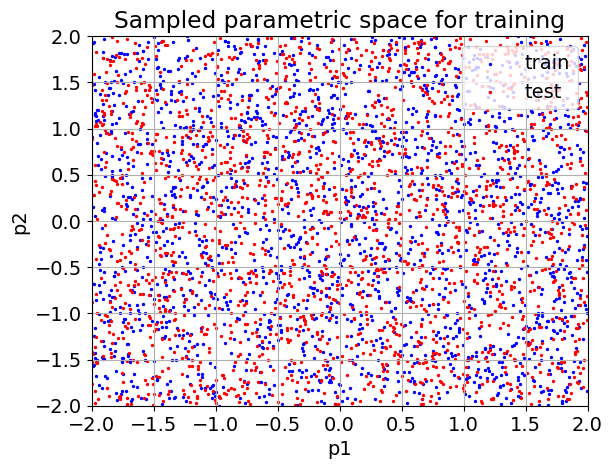

In [28]:

# visualize taining and test samples for 2D parametric space
a_train = samples_train['p1'].numpy()
p_train = samples_train['p2'].numpy()
a_dev = samples_dev['p1'].numpy()
p_dev = samples_dev['p2'].numpy()
plt.figure()
plt.scatter(a_train, p_train, s=2., c='blue', marker='o')
plt.scatter(a_dev, p_dev, s=2., c='red', marker='o')
plt.title('Sampled parametric space for training')
plt.xlim(p_low, p_high)
plt.ylim(p_low, p_high)
plt.grid(True)
plt.xlabel('p1')
plt.ylabel('p2')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.show(block=True)


# pQP Formulation in NeuroMANCER

## Primal Solution Map Architecture

In [29]:
# define neural architecture for the solution map
func = blocks.MLP(insize=2, outsize=2,
                bias=True,
                linear_map=slim.maps['linear'],
                nonlin=nn.ReLU,
                hsizes=[80] * 4)
# define symbolic solution map with concatenated features (problem parameters)
xi = lambda p1, p2: torch.cat([p1, p2], dim=-1)
features = Node(xi, ['p1', 'p2'], ['xi'], name='features')
sol_map = Node(func, ['xi'], ['x'], name='map')
# trainable components of the problem solution
components = [features, sol_map]

## Objective and Constraints in NeuroMANCER

In [30]:
"""
variable is a basic symbolic abstraction in Neuromancer
   x = variable("variable_name")                      (instantiates new variable)  
variable construction supports:
   algebraic expressions:     x**2 + x**3 + 5     (instantiates new variable)  
   slicing:                   x[:, i]             (instantiates new variable)  
   pytorch callables:         torch.sin(x)        (instantiates new variable)  
   constraints definition:    x <= 1.0            (instantiates Constraint object) 
   objective definition:      x.minimize()        (instantiates Objective object) 
to visualize computational graph of the variable use x.show() method          
"""



# variables
x = variable("x")[:, [0]]
y = variable("x")[:, [1]]
# sampled parameters
p1 = variable('p1')
p2 = variable('p2')
# objective function
f = x ** 2 + y ** 2
obj = f.minimize(weight=1.0, name='obj')
objectives = [obj]
# constraints
Q_con = 100.
g1 = -x - y + p1
con_1 = Q_con * (g1 <= 0)
con_1.name = 'c1'
g2 = x + y - p1 - 1
con_2 = Q_con*(g2 <= 0)
con_2.name = 'c2'
g3 = x - y + p2 - 1
con_3 = Q_con*(g3 <= 0)
con_3.name = 'c3'
g4 = -x + y - p2
con_4 = Q_con*(g4 <= 0)
con_4.name = 'c4'
constraints = [con_1, con_2, con_3, con_4]

In [31]:
# create penalty method loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)

## Parametric Problem Solution in NeuroMANCER

In [32]:
lr = 0.001      # step size for gradient descent
epochs = 200    # number of training epochs
warmup = 100    # number of epochs to wait before enacting early stopping policy
patience = 100  # number of epochs with no improvement in eval metric to allow before early stopping

In [33]:

optimizer = torch.optim.AdamW(problem.parameters(), lr=lr)
# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=epochs,
    patience=patience,
    warmup=warmup,
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="test_loss",
    eval_metric="dev_loss",
)


In [34]:
# Train NLP solution map
best_model = trainer.train()
best_outputs = trainer.test(best_model)
# load best model dict
problem.load_state_dict(best_model)

epoch: 0  train_loss: 81.3269271850586
epoch: 1  train_loss: 4.075157165527344
epoch: 2  train_loss: 1.4033559560775757
epoch: 3  train_loss: 1.1939805746078491
epoch: 4  train_loss: 1.1011816263198853
epoch: 5  train_loss: 1.0604759454727173
epoch: 6  train_loss: 1.0673084259033203
epoch: 7  train_loss: 1.066044807434082
epoch: 8  train_loss: 1.110221028327942
epoch: 9  train_loss: 1.0513293743133545
epoch: 10  train_loss: 1.0366902351379395
epoch: 11  train_loss: 0.9689551591873169
epoch: 12  train_loss: 0.9624499082565308
epoch: 13  train_loss: 1.147200584411621
epoch: 14  train_loss: 1.1707956790924072
epoch: 15  train_loss: 1.1377201080322266
epoch: 16  train_loss: 1.0608768463134766
epoch: 17  train_loss: 1.0397297143936157
epoch: 18  train_loss: 1.0860965251922607
epoch: 19  train_loss: 1.1022344827651978
epoch: 20  train_loss: 1.2006560564041138
epoch: 21  train_loss: 1.0307044982910156
epoch: 22  train_loss: 0.9958203434944153
epoch: 23  train_loss: 0.9325623512268066
epoch: 2

<All keys matched successfully>

## Add On A Correction Layer

To improve the feasibility and optimality of the predicted solutions from the learned solution map we add on a correction layer that applies a trainable iterative solver. We train the solver iterations to converge faster for the specific problem and problem parameters.

Here we demonstrate the use of trainable operator splitting methods. The methods have been constructed for problems of the form

$$
    \begin{align}
    & \min f(x)   \\
    & \text{subject to:} \\
    & F_{ineq}(x) <= 0 \\
    & F_{eq}(x)= 0 \\
    \end{align}
$$


These trainable operator splitting methods utilize proximal operators where
$$
prox_g(x) = \argmin_y g(y) + \frac{1}{2\gamma}|| x - y ||^2_{M}
$$
with respect to a Metric $M$, defined by a positive definite matrix

We learn a mapping from problem parameters $p$ to the best metric $M$ to improve convergence.


The solver iterations use a second order approximation of the objective and first order approximation of the constraints. These will be exact here as the problem in this example is quadratic with linear constraints




### Additional Detail

For the methods implemented here the problem is reformulated as

$$
    \begin{align}
    & \min f(x) \\
    & \text{subject to:} \\
    & F(x,s) = 0 \\
    & s>=0 \\
    \end{align}
$$

for slack variables $s$, and $F(x,s)$ defined as
$$
F(x,s) = \begin{bmatrix} F_{eq}(x) \\ F_{ineq}(x) + s \end{bmatrix}
$$

Here operator splitting approaches are applied to the splitting

$$
\min g_1(x,s) + g_2(x,s)
$$

with
$$
\begin{align}
    & g_1(x,s) = f(x) + i_{ \{ (x,s) : F(x,s) = 0 \} } \\
    & g_2(x) = i_{ \{ s : s>=0 \}} 
\end{align}
$$


where $i_{S}$ is the indicator function on set S.


In this implementation for a given x the prox operator of $g_1$ is computed for the approximation
$$
f(x) + \nabla_f(x)^T(y - x) + (y-x)^T H_f(x) (y-x) + i_{ \{ y: F(x) + J_F(x)*(y - x) = 0 \}}
$$
with $\nabla_f(x)$ the gradient of f at x, $H_f(x)$ the hessian of f at x, and  $J_F(x)$ the Jacobian of F at x


In [42]:
#redefine the problem objective and constraints for compatability with the correction layer.

#objective
def f_obj(x,parms):
    return torch.pow( x[0] ,2) + torch.pow( x[1], 2)

#constraints
def F_ineq(x,parms):
    c_1 = -x[0] - x[1] + parms[0]
    c_2 = x[0] + x[1] - parms[0] - 1 
    c_3 = x[0] - x[1] + parms[1] - 1 
    c_4 = -x[0] + x[1] - parms[1]
    return torch.stack((c_1,c_2,c_3,c_4))

#problem size
x_dim = 2 # dimension of primal variable
n_ineq = 4 #number of inequality constraints
parm_dim = 2 #dimension of parameters for problem


## Define a Trainable Metric

In [36]:

#Define a metric that will be trained
#here we define the metric to be a diagonal matrix with bounds on the diagonal to ensure it will be positive definite
lb_P = 1.0/5.0 #upper bound of diagonal 
ub_P = 5.0 # lower bound on diagonal
scl_lb_P = 0.005 #lower bound on scaling coefficient for diagonal
scl_ub_P = 1.0 # upper bound on scaling coefficient for diagonal
n_dim = x_dim + n_ineq
metric = lopo.ParaMetricDiagonal(n_dim,parm_dim,ub_P,lb_P,scl_upper_bound=scl_ub_P,scl_lower_bound=scl_lb_P)

## Initialize The Solver

In [37]:
''' 
Can choose either DR for Douglas Rachford or ADMM for Alternating Direction Method of Multipliers
'''
solver = 'DR'
#solver = 'ADMM'

num_steps = 15 # number of iterations to take

if solver == 'DR':
    solver = lopo.DRSolver(
        f_obj = f_obj, 
        F_ineq = F_ineq,
        x_dim = x_dim, 
        n_ineq = n_ineq, 
        JF_fixed=True,
        Hf_fixed = True,
        num_steps = num_steps,
        metric = metric
        )
if solver == 'ADMM':
    solver = lopo.ADMMSolver(
        f_obj = f_obj, 
        F_ineq = F_ineq,
        x_dim = x_dim, 
        n_ineq = n_ineq, 
        JF_fixed=True,
        Hf_fixed = True,
        num_steps = num_steps,
        metric = metric
        )


## Remap Solution Through Correction Layer

In [38]:

sol_map = Node(func, ['xi'], ['x_predicted'], name='map')
correction = Node(solver,['x_predicted','xi'],['x','cnv_gap'])
components = [features, sol_map, correction]
### ADD A CONVERGENCE PENALTY TO TRAIN SOLVER
cnv_gap = variable("cnv_gap")
f_cnv = cnv_gap
cnv_obj = f_cnv.minimize(weight=1e8, name='cnv_obj')
objectives = [cnv_obj]
constraints = []
# create loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)


## Train the Metric For The Correction Layer

In [39]:

optimizer = torch.optim.AdamW(solver.parameters(), lr=1e-2)
# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=20,
    patience=200,
    warmup=100,
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="test_loss",
    eval_metric="dev_loss",
)
# Train solution map
best_model = trainer.train()

epoch: 0  train_loss: 57.85216522216797
epoch: 1  train_loss: 0.39614301919937134
epoch: 2  train_loss: 0.10252819955348969
epoch: 3  train_loss: 0.06580999493598938
epoch: 4  train_loss: 0.056206829845905304
epoch: 5  train_loss: 0.05221138149499893
epoch: 6  train_loss: 0.049075592309236526
epoch: 7  train_loss: 0.046760257333517075
epoch: 8  train_loss: 0.04377736151218414
epoch: 9  train_loss: 0.042454905807971954
epoch: 10  train_loss: 0.04118578881025314
epoch: 11  train_loss: 0.038812071084976196
epoch: 12  train_loss: 0.0388730950653553
epoch: 13  train_loss: 0.03612465411424637
epoch: 14  train_loss: 0.03684256225824356
epoch: 15  train_loss: 0.035643357783555984
epoch: 16  train_loss: 0.034114085137844086
epoch: 17  train_loss: 0.03407121077179909
epoch: 18  train_loss: 0.03349055349826813
epoch: 19  train_loss: 0.03293275460600853


## Compare to CVXPY Solver

/var/folders/5t/0jpw47ds3rs3_fzmw9fk919w0000gn/T/ipykernel_28934/3973339004.py:33: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cp_plot = ax[row_id, column_id].contourf(xx, yy, J, 50, alpha=0.4,cmap = mpl.colormaps['bone'],linewidth = 10)
/var/folders/5t/0jpw47ds3rs3_fzmw9fk919w0000gn/T/ipykernel_28934/3973339004.py:43: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  plt.setp(cg1.collections,
/var/folders/5t/0jpw47ds3rs3_fzmw9fk919w0000gn/T/ipykernel_28934/3973339004.py:45: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  plt.setp(cg2.collections,
/var/folders/5t/0jpw47ds3rs3_fzmw9fk919w0000gn/T/ipykernel_28934/3973339004.py:47: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  plt.setp(cg3.collect

primal solution x=[0.5], y=[-0.75]
parameter p=(-1.25, -1.25)
primal solution Neuromancer x1=0.500011146068573, x2=-0.7499968409538269
primal solution x=[0.5], y=[-0.5]
parameter p=(-1.0, -1.0)
primal solution Neuromancer x1=0.4999542534351349, x2=-0.50002121925354
primal solution x=[0.25], y=[-0.25]
parameter p=(-0.5, -0.5)
primal solution Neuromancer x1=0.24998660385608673, x2=-0.2499862015247345
primal solution x=[0.125], y=[-0.125]
parameter p=(-0.25, -0.25)
primal solution Neuromancer x1=0.12502336502075195, x2=-0.12499527633190155
primal solution x=[0.], y=[0.]
parameter p=(0.0, 0.0)
primal solution Neuromancer x1=5.817413330078125e-05, x2=-1.601874828338623e-06
primal solution x=[0.125], y=[0.125]
parameter p=(0.25, 0.25)
primal solution Neuromancer x1=0.12505045533180237, x2=0.12500010430812836
primal solution x=[0.25], y=[0.25]
parameter p=(0.5, 0.5)
primal solution Neuromancer x1=0.24999910593032837, x2=0.249983549118042
primal solution x=[0.5], y=[0.5]
parameter p=(1.0, 1.0)

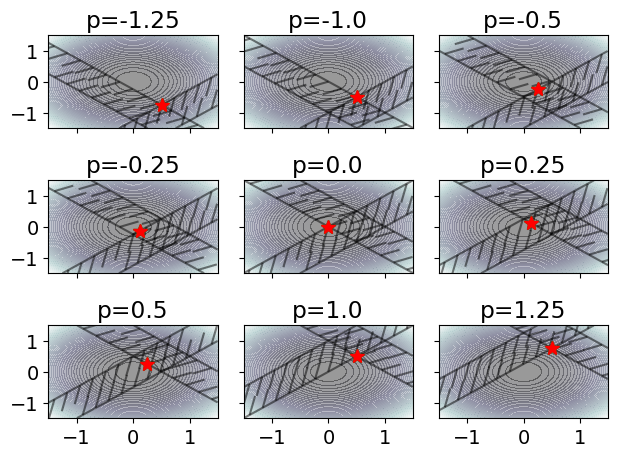

In [40]:
"""
CVXPY benchmarks
"""
# Define the CVXPY problems.
def QP_param(p1, p2):
    x = cp.Variable(1)
    y = cp.Variable(1)
    prob = cp.Problem(cp.Minimize(x ** 2 + y ** 2),
                        [-x - y + p1 <= 0,
                        x + y - p1 - 1 <= 0,
                        x - y + p2 - 1 <= 0,
                        -x + y - p2 <= 0])
    return prob, x, y
"""
Plots
"""
import matplotlib as mpl
plt.rcParams.update({'font.size': 14})
# test problem parameters
params = [-1.25, -1.0, -0.5, -0.25, 0.0, 0.25, 0.5, 1.0, 1.25]
x1 = np.arange(-1.5, 1.5, 0.01)
y1 = np.arange(-1.5, 1.5, 0.01)
xx, yy = np.meshgrid(x1, y1)
fig, ax = plt.subplots(3,3,sharex = True,sharey=True)
row_id = 0
column_id = 0
for i, p in enumerate(params):
    if i % 3 == 0 and i != 0:
        row_id += 1
        column_id = 0
    # eval and plot objective and constraints
    J = xx ** 2 + yy ** 2
    cp_plot = ax[row_id, column_id].contourf(xx, yy, J, 50, alpha=0.4,cmap = mpl.colormaps['bone'],linewidth = 10)
    ax[row_id, column_id].set_title(f'p={p}')
    c1 = xx + yy - p
    c2 = -xx - yy + p + 1
    c3 = -xx + yy - p + 1
    c4 = xx - yy + p
    cg1 = ax[row_id, column_id].contour(xx, yy, c1, [0], colors='k', alpha=0.5)
    cg2 = ax[row_id, column_id].contour(xx, yy, c2, [0], colors='k', alpha=0.5)
    cg3 = ax[row_id, column_id].contour(xx, yy, c3, [0], colors='k', alpha=0.5)
    cg4 = ax[row_id, column_id].contour(xx, yy, c4, [0], colors='k', alpha=0.5)
    if hasattr(cg1, 'collections') and cg1.collections:
        plt.setp(cg1.collections,
                    path_effects=[patheffects.withTickedStroke()], alpha=0.5)
        plt.setp(cg2.collections,
                    path_effects=[patheffects.withTickedStroke()], alpha=0.5)
        plt.setp(cg3.collections,
                    path_effects=[patheffects.withTickedStroke()], alpha=0.5)
        plt.setp(cg4.collections,
                    path_effects=[patheffects.withTickedStroke()], alpha=0.5)
    # Solve CVXPY problem
    prob, x, y = QP_param(p, p)
    prob.solve()
    # Solve via neuromancer
    datapoint = {'p1': torch.tensor([[p]]), 'p2': torch.tensor([[p]]),
                    'name': 'test'}
    model_out = problem(datapoint)
    x_nm = model_out['test_' + "x"][0, 0].detach().numpy()
    y_nm = model_out['test_' + "x"][0, 1].detach().numpy()
    print(f'primal solution x={x.value}, y={y.value}')
    print(f'parameter p={p, p}')
    print(f'primal solution Neuromancer x1={x_nm}, x2={y_nm}')
    # Plot optimal solutions
    ax[row_id, column_id].plot(x.value, y.value, 'g*', markersize=10)
    ax[row_id, column_id].plot(x_nm, y_nm, 'r*', markersize=10)
    column_id += 1
fig.tight_layout()
plt.show()
plt.show(block=True)
plt.interactive(False)




In [41]:
"""
Benchmark Solution
"""
def eval_constraints(x, y, p1, p2):
    """
    evaluate mean constraints violations
    """
    con_1_viol = np.maximum(0, -x - y + p1)
    con_2_viol = np.maximum(0, x + y - p1 - 1)
    con_3_viol = np.maximum(0, x - y + p2 - 1)
    con_4_viol = np.maximum(0, -x + y - p2)
    con_viol = con_1_viol + con_2_viol + con_3_viol + con_4_viol
    con_viol_mean = np.mean(con_viol)
    return con_viol_mean
def eval_objective(x, y, a1=1, a2=1):
    obj_value_mean = np.mean(a1 * x**2 + a2 * y**2)
    return obj_value_mean
# Solve via neuromancer
with torch.no_grad():
    t = time.time()
    samples_test['name'] = 'test'
    model_out = problem(samples_test)
    nm_time = time.time() - t
x_nm = model_out['test_' + "x"][:, [0]].detach().numpy()
y_nm = model_out['test_' + "x"][:, [1]].detach().numpy()
x_nm_noDR = model_out['test_x_predicted'][:, [0]].detach().numpy()
y_nm_noDR = model_out['test_x_predicted'][:, [1]].detach().numpy()
# Solve via solver
t = time.time()
x_solver, y_solver = [], []
for i in range(0, nsim):
    p1 = samples_test['p1'][i].detach().numpy()
    p2 = samples_test['p2'][i].detach().numpy()
    prob, x, y = QP_param(p1, p2)
    prob.solve(solver='OSQP', verbose=False)
    prob.solve()
    x_solver.append(x.value)
    y_solver.append(y.value)
solver_time = time.time() - t
x_solver = np.asarray(x_solver)
y_solver = np.asarray(y_solver)
p1_vec = samples_test['p1'].detach().numpy()
p2_vec = samples_test['p2'].detach().numpy()

# Evaluate solver solution
print(f'Solution for {nsim} problems via CVXPY obtained in {solver_time:.4f} seconds')
solver_con_viol_mean = eval_constraints(x_solver, y_solver, p1_vec, p2_vec)
print(f'CVXPY mean constraints violation {solver_con_viol_mean:.4f}')
solver_obj_mean = eval_objective(x_solver, y_solver)
print(f'CVXPY mean objective value {solver_obj_mean:.4f}\n')

# Evaluate neuromancer solution no DR
nm_con_viol_mean = eval_constraints(x_nm_noDR, y_nm_noDR, p1_vec, p2_vec)
print(f'Neuromancer mean constraints violation no correction {nm_con_viol_mean:.4f}')
nm_obj_mean = eval_objective(x_nm_noDR, y_nm_noDR)
print(f'Neuromancer mean objective value no correction {nm_obj_mean:.4f}')

# Difference in primal optimizers
dx = (x_solver - x_nm_noDR)[:,0]
dy = (y_solver - y_nm_noDR)[:,0]
err_x = np.mean(dx**2)
err_y = np.mean(dy**2)
err_primal = err_x + err_y
print('MSE primal optimizers no correction:', err_primal)

# Difference in objective
err_obj = np.abs(solver_obj_mean - nm_obj_mean) / solver_obj_mean * 100
print(f'mean objective value discrepancy np correction: {err_obj:.2f} % \n')



# Evaluate neuromancer solution
print(f'Solution for {nsim} problems with correction obtained in {nm_time:.4f} seconds')
nm_con_viol_mean = eval_constraints(x_nm, y_nm, p1_vec, p2_vec)
print(f'mean constraints violation with correction {nm_con_viol_mean:.4f}')
nm_obj_mean = eval_objective(x_nm, y_nm)
print(f'mean objective value with correction {nm_obj_mean:.4f}')


# neuromancer solver comparison
speedup_factor = solver_time/nm_time
print(f'Solution speedup factor {speedup_factor:.4f}')

# Difference in primal optimizers0
dx = (x_solver - x_nm)[:,0]
dy = (y_solver - y_nm)[:,0]
err_x = np.mean(dx**2)
err_y = np.mean(dy**2)
err_primal = err_x + err_y
err_primal = np.mean((dx**2 + dy**2))
rel_err_primal = np.mean((dx**2 + dy**2))/np.mean((x_solver**2 + y_solver**2 ))
print('MSE primal optimizers:', rel_err_primal)

# Difference in objective
err_obj = np.abs(solver_obj_mean - nm_obj_mean) / solver_obj_mean * 100
print(f'mean objective value discrepancy: {err_obj:.2f} %')


Solution for 2000 problems via CVXPY obtained in 12.3171 seconds
CVXPY mean constraints violation 0.0000
CVXPY mean objective value 0.7382

Neuromancer mean constraints violation no correction 0.0002
Neuromancer mean objective value no correction 0.8378
MSE primal optimizers no correction: 0.016542269751206266
mean objective value discrepancy np correction: 13.50 % 

Solution for 2000 problems with correction obtained in 0.0216 seconds
mean constraints violation with correction 0.0000
mean objective value with correction 0.7382
Solution speedup factor 569.9781
MSE primal optimizers: 1.0437864019287642e-09
mean objective value discrepancy: 0.00 %
